In [1]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import joblib  # To load the trained model
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
#Importing the dataset
data=pd.read_csv("IEA GEVO 2023 data.csv")
year_to_delete=[2010,2011,2012,2025,2030]
df=data.loc[~data['year'].isin(year_to_delete)]

#Deleting regions which are not applicable for analysis
region_to_delete=['EU27','Other Europe','Rest of the world','World']
df=df.loc[~df['region'].isin(region_to_delete)]

#Deleting parameters which are not applicable for analysis
parameter_to_delete=['EV sales share', 'EV stock share','EV stock','Oil displacement, million lge','Oil displacement Mbd','EV charging points','Electricity demand']
df=df.loc[~df['parameter'].isin(parameter_to_delete)]

#Deleting categorys which are not applicable for analysis
category_to_delete=['Projection-STEPS','Projection-APS']
df=df.loc[~df['category'].isin(category_to_delete)]

df1 = df.groupby('year')['value'].sum().reset_index()
ar_model1 = AutoReg(df1['value'],lags = 1)
ar_result1 = ar_model1.fit()

In [2]:
import joblib
# Save the model to a file
model_filename = "ar_country.pkl"
joblib.dump(ar_result1, model_filename)

['ar_country.pkl']

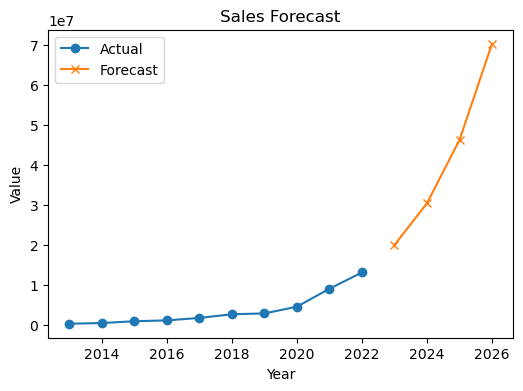

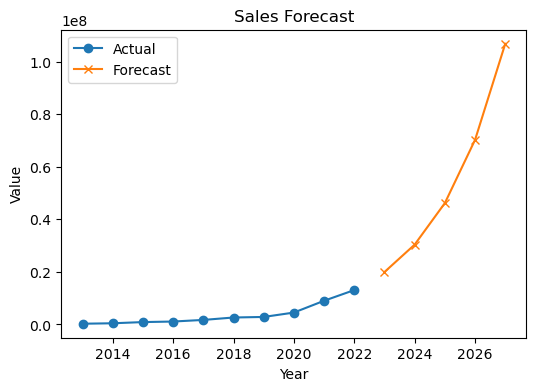

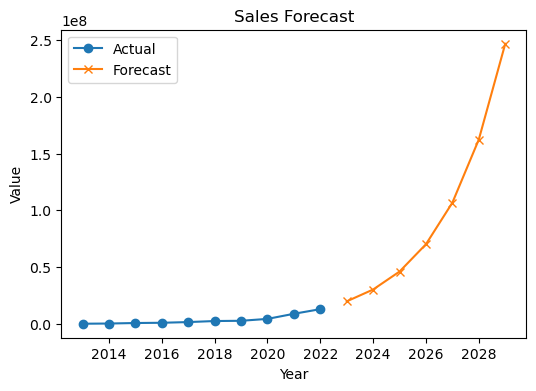

In [4]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# Create the main window
root = tk.Tk()
root.title("Time Series Forecasting GUI")

# Load the trained forecasting model
model = joblib.load("ar_country.pkl")  # Replace with your model filename

canvas=None

def get_forecast():
    global canvas
    if canvas:
        canvas.get_tk_widget().destroy()
    selected_year = int(year_var.get())
    df1.index = pd.to_datetime(df1.year, format='%Y')
    last_year = df1.index[-1].year
    year=selected_year-last_year
    forecast = model.predict(start=len(df1), end=len(df1) + year - 1, dynamic=False)
    # Create a date range for the forecasted years
    next_year_date = last_year + 1
    next_years_range = pd.date_range(start=f"{next_year_date}-01-01", periods=year, freq='AS')
    forecast_df = pd.DataFrame({'year': next_years_range, 'value': forecast})
    forecast_df['value'] = forecast_df['value'].astype('int64')
    result_label.config(text=forecast_df)
    
    # Plot the actual vs. forecasted values
    fig,ax=plt.subplots(figsize=(6, 4))
    plt.plot(df1.index, df1['value'], label='Actual', marker='o')
    plt.plot(forecast_df['year'], forecast_df['value'], label='Forecast', marker='x')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title('Sales Forecast')
    plt.legend()
    plt.show()
    canvas=FigureCanvasTkAgg(fig, master=root)
    canvas_widget=canvas.get_tk_widget()
    canvas_widget.pack()

def clear_results():
    year_dropdown.delete(0, 'end')
    result_label.config(text="")
    global canvas
    if canvas:
        canvas.get_tk_widget().destroy()
    
# Year selection
year_label = tk.Label(root, text="Select a Year:")
year_label.pack()
year_var = tk.StringVar()
year_dropdown = ttk.Combobox(root, textvariable=year_var, values=list(range(2023, 2031)))
year_dropdown.pack()

# Forecast button
forecast_button = tk.Button(root, text="Get Forecast", command=get_forecast)
forecast_button.pack()

clear_button = tk.Button(root, text="Clear", command=clear_results)
clear_button.pack()

# Result label
result_label = tk.Label(root, text="")
result_label.pack()

root.mainloop()